## Climada Avalanche


This notebook describes how to reproduce the results and figures published in [Large-scale risk assessment on snow avalanche hazard in alpine regions](https://doi.org/10.5194/nhess-2022-112).
Using hazard exposure and vulnerability, the impacts that result from an artificially created avalanche hazard set in the papers case study area are calculated. An uncertainty and sensitivity analysis was carried out and thus the potential risks were described. 

All data necessary for running this skript are publicly available on ENVIDAT www.envidat.ch with the link: https://www.doi.org/10.16904/envidat.398. The data should be placed into the folder `data`.

For more information on the functionality of Climada, please see the Climada documentation. 

In [1]:
#This file is part of the CLIMADA papers repository: 
#https://github.com/CLIMADA-project/climada_papers

# Copyright (C) 2023 ETH Zurich, CLIMADA contributors listed in AUTHORS.

# Created on Wed May 03 09:30:35 2023

# @author: Gregor Ortner 
# @author: Chahan Kropf

In [ ]:
import os
import math
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as crs
import scipy.sparse as sparse

import copy
import requests
import glob
import h5py

from pathlib import Path
from math import e
from matplotlib import colors

from climada.engine.unsequa import UncOutput, InputVar, CalcImpact
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.engine import ImpactCalc
from climada.hazard import Hazard
from climada.entity import Exposures
from climada.engine import Impact
from climada.util import ENT_TEMPLATE_XLS


from climada.util.files_handler import get_file_names

CWD = Path.cwd()
DATA = Path("./data/") #change the path to your working directory

### Hazard 
This part generates the Climda Hazard class for avalanches from geo tiff files which were generated with RAMMS avalanche simulation software in advance. These files can be read on by one as single files or you can use the provided ".hdf5" files. 

In [3]:
#define hazard with all properties
def create_AV_hazard_tif(rp, region, year=2021, crs='WGS84'):
    folder = DATA / (str(year) + '_HAZ_ALL_' + str(rp) + '_' + crs)
    file_names = get_file_names(str(folder / (region + '*.tif'))) # get all file_names in a list
    haz = Hazard('AV')
    haz = haz.from_raster(file_names, haz_type = 'AV') # initialize the hazard (centroids etc) with the first file
    haz.event_id = np.array([int(x.split('_')[-2]) for x in file_names])
    haz.frequency = np.repeat(1.0/rp,haz.size)# defining the return period
    haz.check()
    return haz

You can create your own hazard by providing your geo tiff (or the tiffs available at ENVIDAT), depending on the number of tiffs to read it might take a while, so better to use the the provided .hdf5 from the projectfolder on ENVIDAT

In [4]:
#haz_goe_300 = Hazard('AV')
#haz_goe_300 = create_AV_hazard_tif(300, 'Goeschenen', crs='WGS84')
#haz_goe_300.write_hdf5(DATA/'Hazard_URI_300.hdf5')

#haz_goe_100 = Hazard('AV')
#haz_goe_100 = create_AV_hazard_tif(100, 'Goeschenen', crs='WGS84')
#haz_goe_100.write_hdf5(DATA/'Hazard_URI_100.hdf5')

#haz_goe_30 = Hazard('AV')
#haz_goe_30 = create_AV_hazard_tif(30, 'Goeschenen', crs='WGS84')
#haz_goe_30.write_hdf5(DATA/'Hazard_URI_30.hdf5')

Reading of previously provided .hdf5 files from the project folder

In [5]:
haz_goe_30 = Hazard('AV')
Hazard_URI_30 = DATA / 'Hazard_URI_30.hdf5'
haz_goe_30 = haz_goe_30.from_hdf5(Hazard_URI_30)

haz_goe_100 = Hazard('AV')
Hazard_URI_100 = DATA / 'Hazard_URI_100.hdf5'
haz_goe_100 =haz_goe_100.from_hdf5(Hazard_URI_100)

haz_goe_300 = Hazard('AV')
Hazard_URI_300 = DATA / 'Hazard_URI_300.hdf5'
haz_goe_300 = haz_goe_300.from_hdf5(Hazard_URI_300)

### Exposure
Here we define the Climada Exposure class. It is read in from a geodataframe generated as described in the paper. This geodataframe defines the exposed buildings with coordinates and their monetary values. It is also provided as geodataframe (.gdf) as well as .hdf5 file for easy usesage.

In [6]:
Building_file_all = Ext / Path()
damagepot_Building_all = gpd.read_file(Building_file_all) #read "point"-geodataframe

In [7]:
# defines the Exposure and reads the .hdf5
Exposure_file_name = DATA / 'Buildings.hdf5'
exp_damagepot_buil_all = Exposures.from_hdf5(Exposure_file_name)

Shows the used geodataframe

In [8]:
#shows the used geodataframe
exp_damagepot_buil_all.gdf

Z_Min        Z_Max              Building_1  EconoMe_ID  \
0      1427.646000  1433.951000                  Stable           2   
1      1428.395000  1434.848000             Barn_Remise           3   
2      1426.231333  1438.111333  commercial_uninhabited           6   
3      1434.803000  1435.055000    Garage_incl_vehicles           4   
4      1432.200000  1434.204000             Barn_Remise           3   
...            ...          ...                     ...         ...   
13300  1808.544000  1819.167000                  Stable           2   
13301   469.885000   480.546000                  Stable           2   
13302   470.245000   483.652000    Residential_Building          87   
13303   471.214000   481.141000    Residential_Building          87   
13304  1249.824333  1260.136000    Residential_Building           1   

       Value_CHF    value   latitude  longitude  impf_  centr_AV  
0          26364    26364  46.642103   8.592151      1   8340811  
1           7695     7695  46.642178   8.592269      1   8337521  
2        6490147  6490147  46.642010   8.590520      1   8344087  
3          60000    60000  46.642300   8.591092      1   8334220  
4           1730     1730  46.642335   8.589654      1   8334207  
...          ...      ...        ...        ...    ...       ...  
13300     701389   701389  46.911828   8.687050      1    285305  
13301     188299   188299  46.812262   8.653182      1   3260061  
13302     550000   550000  46.812217   8.653489      1   3260064  
13303     550000   550000  46.812162   8.655428      1   3263373  
13304     650000   650000  46.811915   8.678943      1   3270168  

[13305 rows x 10 columns]

#### Distribution of monetary values [CHF] in the case study region

Text(858.7916666666666, 0.5, 'Value (CHF)')

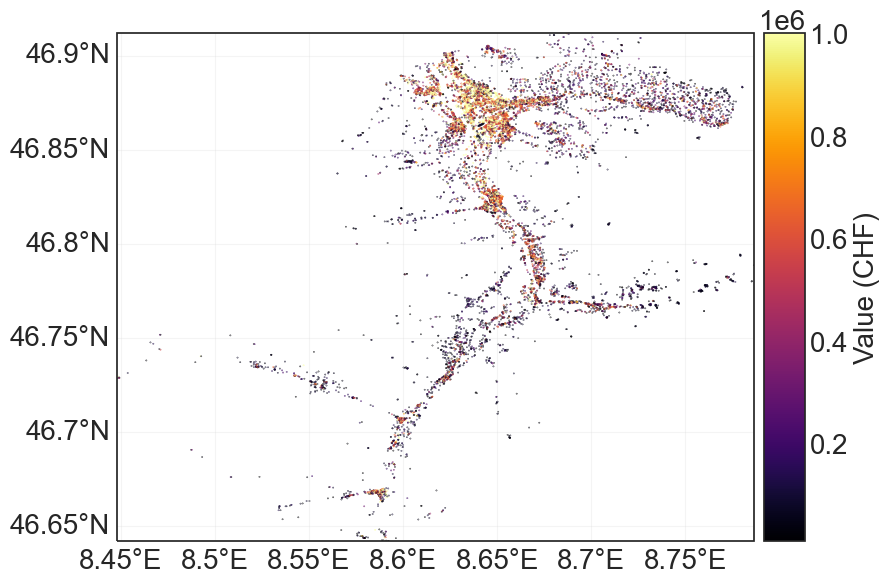

In [10]:
# plotting the monetary values in the project area
exp_damagepot_buil_all.plot_hexbin(vmin=10000, vmax=1000000,cmap = "inferno")
norm=colors.LogNorm(vmin=10000, vmax=1000000)
plt.grid(True)
plt.ylabel("Value (CHF)")

### Vulnerability:  Impact Functions based on "EconoMe"
From the swiss standard risk tool "EconnoMe" (https://econome.ch) the impact values for avalanches were extracted and plotted as impact functions, provided for this Notbook as Excel file available on ENVIDAT. The impact functions define the vulnerability of an object at a certain avalanche pressure in [kPa]. 

Read file: Impf_Set.xls


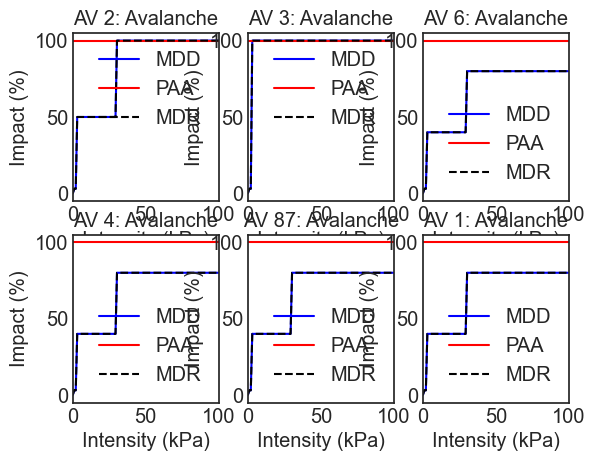

In [11]:
# provide absolute path of the input excel file
file_name = 'Impf_Set.xls'
# fill ImpactFuncSet from Excel file
impf_set = ImpactFuncSet.from_excel(DATA / file_name)

# plot all the impact functions from the ImpactFuncSet
print('Read file:', impf_set.tag.file_name)
impf_set.plot()
# adjust the plots
plt.subplots_adjust()

impf_set.check()

### Impact calculation and risk maps
Using the hazard, the exposure and the impact functions, the expected annual impact is calculated in Swiss francs (CHF) per year for the defined return period. 

Text(0.5, 1.0, 'Expected annual impact for 30y rp')

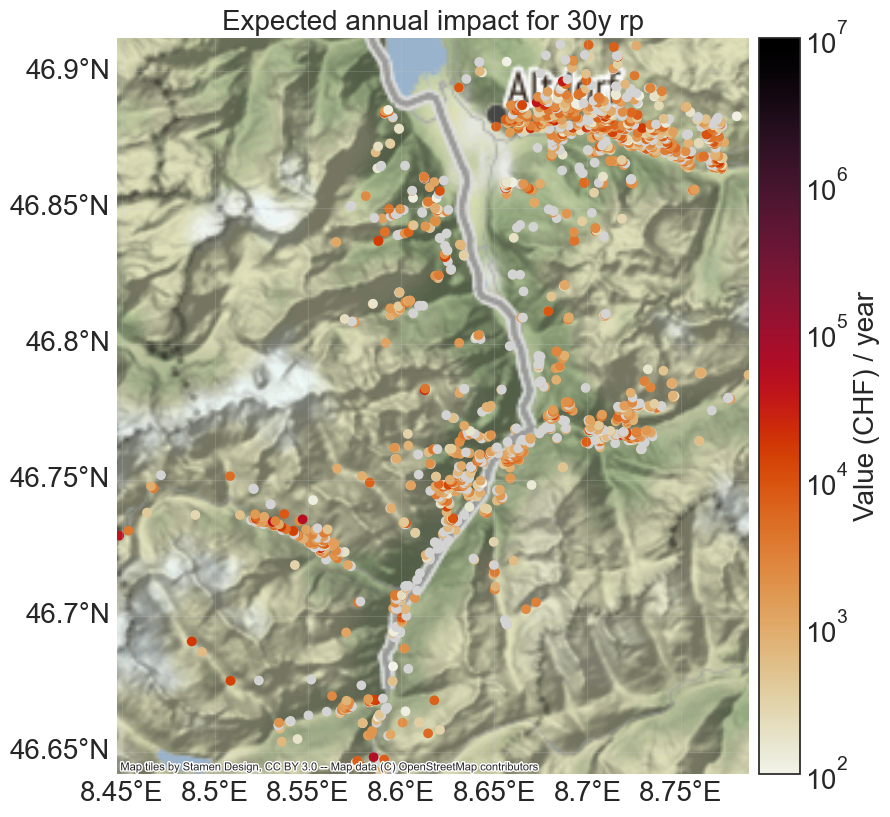

In [12]:
#calculate and plot Impact for 30y return period
imp_Build_30 = ImpactCalc(exp_damagepot_buil_all,impf_set,haz_goe_30).impact()
norm=colors.LogNorm(vmin=100, vmax=10000000)
ax = imp_Build_30.plot_basemap_eai_exposure(buffer=50.0, norm=norm); 
plt.ylabel("Value (CHF) / year" ,fontsize=20)
ax.set_title("Expected annual impact for 30y rp" ,fontsize=20)

Text(0.5, 1.0, 'Expected annual impact for 100y rp')

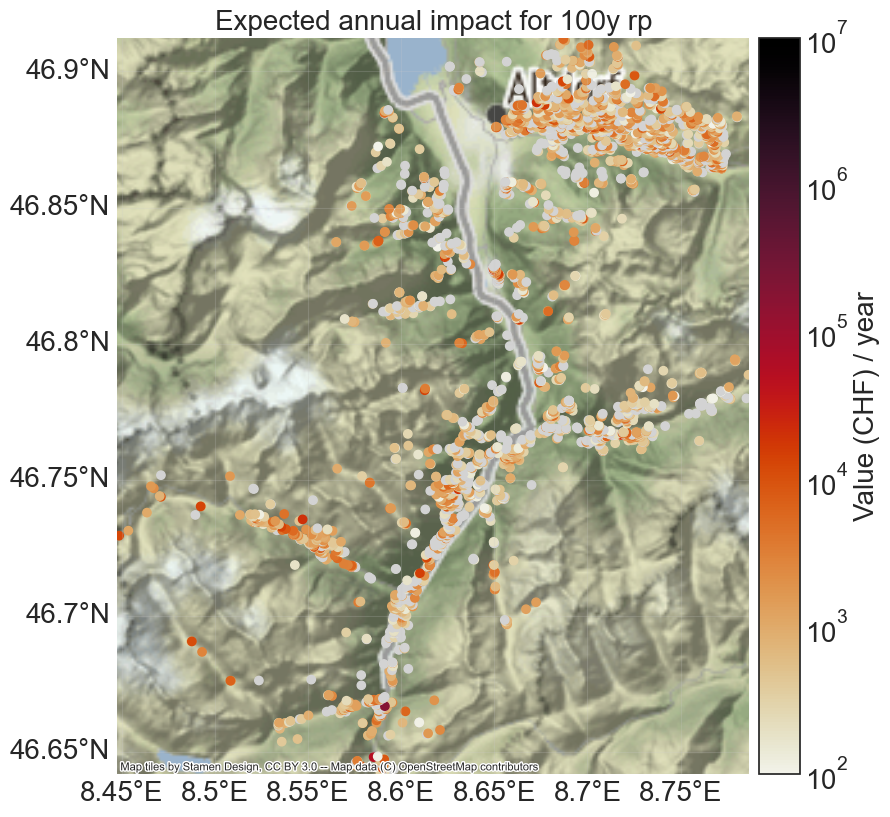

In [13]:
#calculate and plot Impact for 100y return period
imp_Build_100 = ImpactCalc(exp_damagepot_buil_all,impf_set,haz_goe_100).impact()
norm=colors.LogNorm(vmin=100, vmax=10000000)
ax = imp_Build_100.plot_basemap_eai_exposure(buffer=50.0, norm=norm); # average annual impact at each exposure
plt.ylabel("Value (CHF) / year" ,fontsize=20)
ax.set_title("Expected annual impact for 100y rp" ,fontsize=20)

Text(0.5, 1.0, 'Expected annual impact for 300y rp')

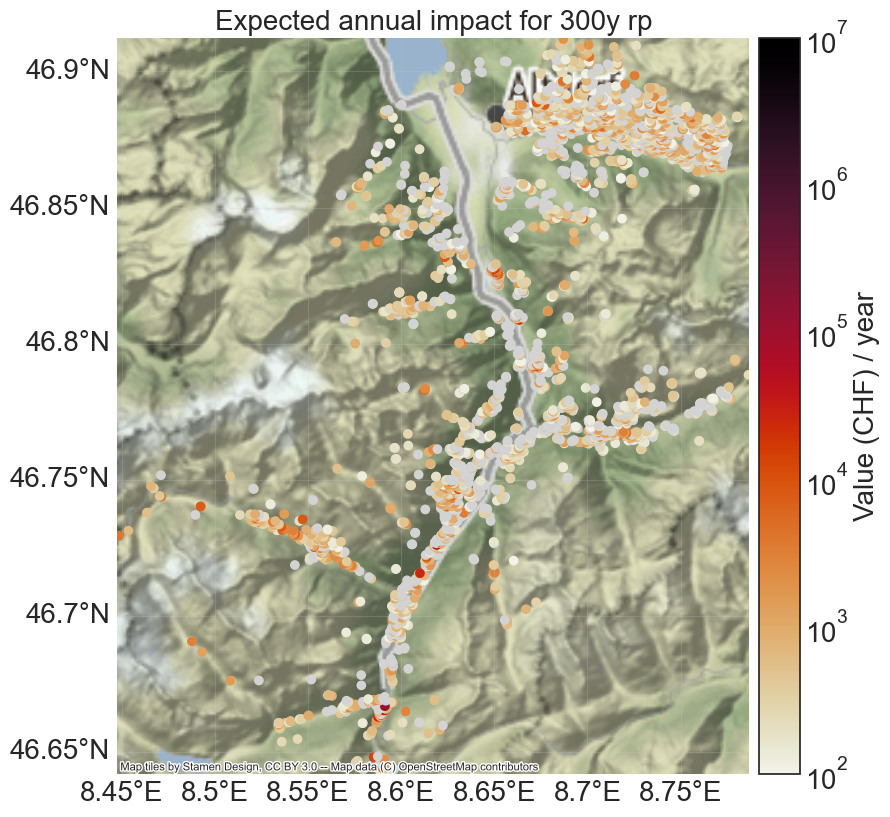

In [14]:
#calculate and plot Impact for 300y return period
imp_Build_300 = ImpactCalc(exp_damagepot_buil_all,impf_set,haz_goe_300).impact()
norm=colors.LogNorm(vmin=100, vmax=10000000)
ax = imp_Build_300.plot_basemap_eai_exposure(buffer=50.0, norm=norm); # average annual impact at each exposure
plt.ylabel("Value (CHF) / year" ,fontsize=20)
ax.set_title("Expected annual impact for 300y rp" ,fontsize=20)

All hazards are combined as described in the paper and the impact of a cobined hazard scenario is calculated and plotted. 

Text(0.5, 1.0, 'Expected annual impact combined')

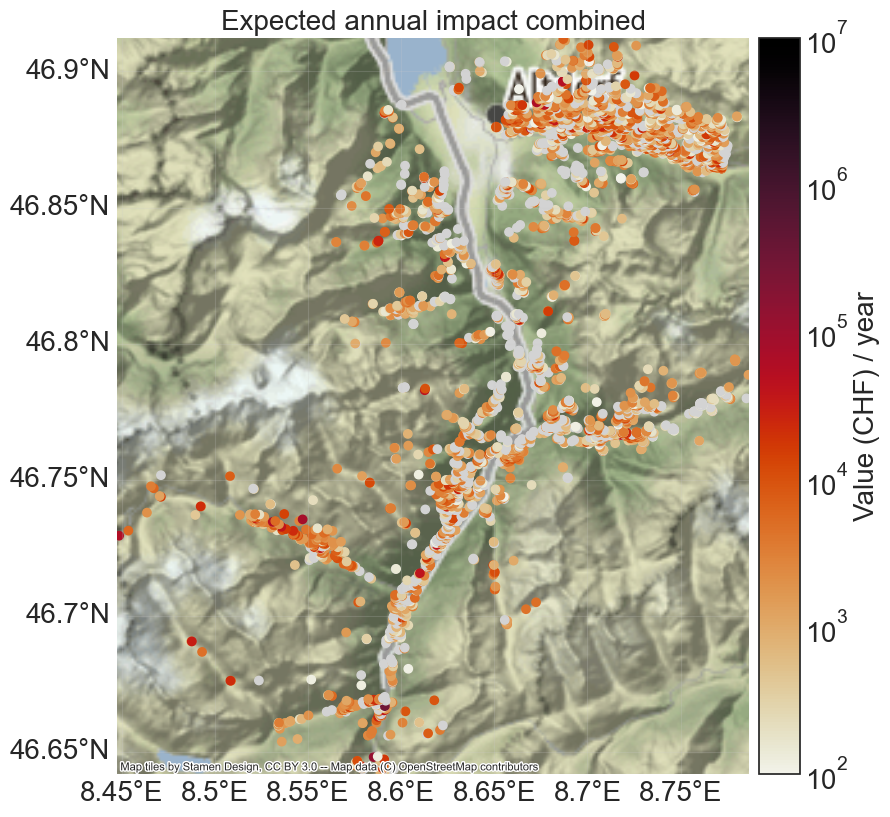

In [15]:
### combine all impacts with concatinate
imp_tot = Impact.concat([imp_Build_30,imp_Build_100,imp_Build_300],reset_event_ids=True)
norm=colors.LogNorm(vmin=100, vmax=10000000)
ax = imp_tot.plot_basemap_eai_exposure(buffer=50.0, norm=norm); # average annual impact at each exposure
plt.ylabel("Value (CHF) / year" ,fontsize=20)
ax.set_title("Expected annual impact combined" ,fontsize=20)

#### Aggregated average annual impact
Calculate the average annual impact aggregated aai_agg (overall risk) for all return periods

In [16]:
print(f"Aggregated average annual impact RP 30: {round(imp_Build_30.aai_agg,0)} CHF")
print(f"Aggregated average annual impact RP 100: {round(imp_Build_100.aai_agg,0)} CHF")
print(f"Aggregated average annual impact RP 300: {round(imp_Build_300.aai_agg,0)} CHF")
print(f"Aggregated average annual impact all hazards combined: {round(imp_tot.aai_agg,0)} CHF")

Aggregated average annual impact RP 30: 4160655.0 CHF
Aggregated average annual impact RP 100: 3825252.0 CHF
Aggregated average annual impact RP 300: 2733473.0 CHF
Aggregated average annual impact all hazards combined: 10719380.0 CHF


#### Export for GIS
For further analysis in GIS software as it was done in the paper, the geodata frames can be exported as follows. 

In [17]:
#export eai RP 30 as csv to use in GIS
coords = imp_Build_30.coord_exp
data30 = imp_Build_30.eai_exp
df30 = pd.DataFrame({'long': coords[:,0], 'lat': coords[:,1], 'eai': data30})
df30.to_csv(DATA / 'impact30.csv')

#export eai RP 100 as csv to use in GIS
coords = imp_Build_100.coord_exp
data100 = imp_Build_100.eai_exp
df100 = pd.DataFrame({'long': coords[:,0], 'lat': coords[:,1], 'eai': data100})
df100.to_csv(DATA / 'impact100.csv')

#export eai RP 300 as csv to use in GIS
coords = imp_Build_300.coord_exp
data300 = imp_Build_300.eai_exp
df300 = pd.DataFrame({'long': coords[:,0], 'lat': coords[:,1], 'eai': data300})
df300.to_csv(DATA / 'impact300.csv')

#export eai RP all as csv to use in GIS
coords = imp_tot.coord_exp
dataall = imp_tot.eai_exp
dfall= pd.DataFrame({'long': coords[:,0], 'lat': coords[:,1], 'eai': dataall})
dfall.to_csv(DATA / 'impactall.csv')

### Uncertainty and sensitivity analysis
Using the Climada Uncertainty and Sensitivity module, the uncertainty ranges are set as described in the paper and the analyses are calculated as shown below. 

In [18]:
bounds_totval = [0.8, 1.2] #setting the uncertainty range for the exposure
exp_iv = InputVar.exp([exp_damagepot_buil_all], bounds_totval=bounds_totval)

bounds_int = [0.5, 1.5] #setting the uncertainty range for the hazard intensity
haz = haz_goe_30 #Choose hazard according to return period
haz_iv = InputVar.haz([haz], bounds_int=bounds_int)

bounds_mdd = [0.6, 1.4] #setting the uncertainty range for the mdd of the vulnerability
haz_id_dict = impf_set.get_ids()
impf_iv = InputVar.impfset([impf_set], bounds_mdd=bounds_mdd, haz_id_dict=haz_id_dict)

calc_imp = CalcImpact(exp_iv, impf_iv, haz_iv);

N = 1000 # Adjust the sample number

unc_sample = calc_imp.make_sample(N=N)

unc_sample.get_samples_df()

ET       MDD        HI
0     0.887891  0.677344  1.018555
1     1.070703  0.677344  1.018555
2     0.887891  0.824219  1.018555
3     0.887891  0.677344  1.407227
4     0.887891  0.824219  1.407227
...        ...       ...       ...
7995  0.831445  1.089453  1.235840
7996  0.831445  1.241797  1.235840
7997  0.996680  1.089453  1.235840
7998  0.996680  1.241797  0.634277
7999  0.996680  1.241797  1.235840

[8000 rows x 3 columns]

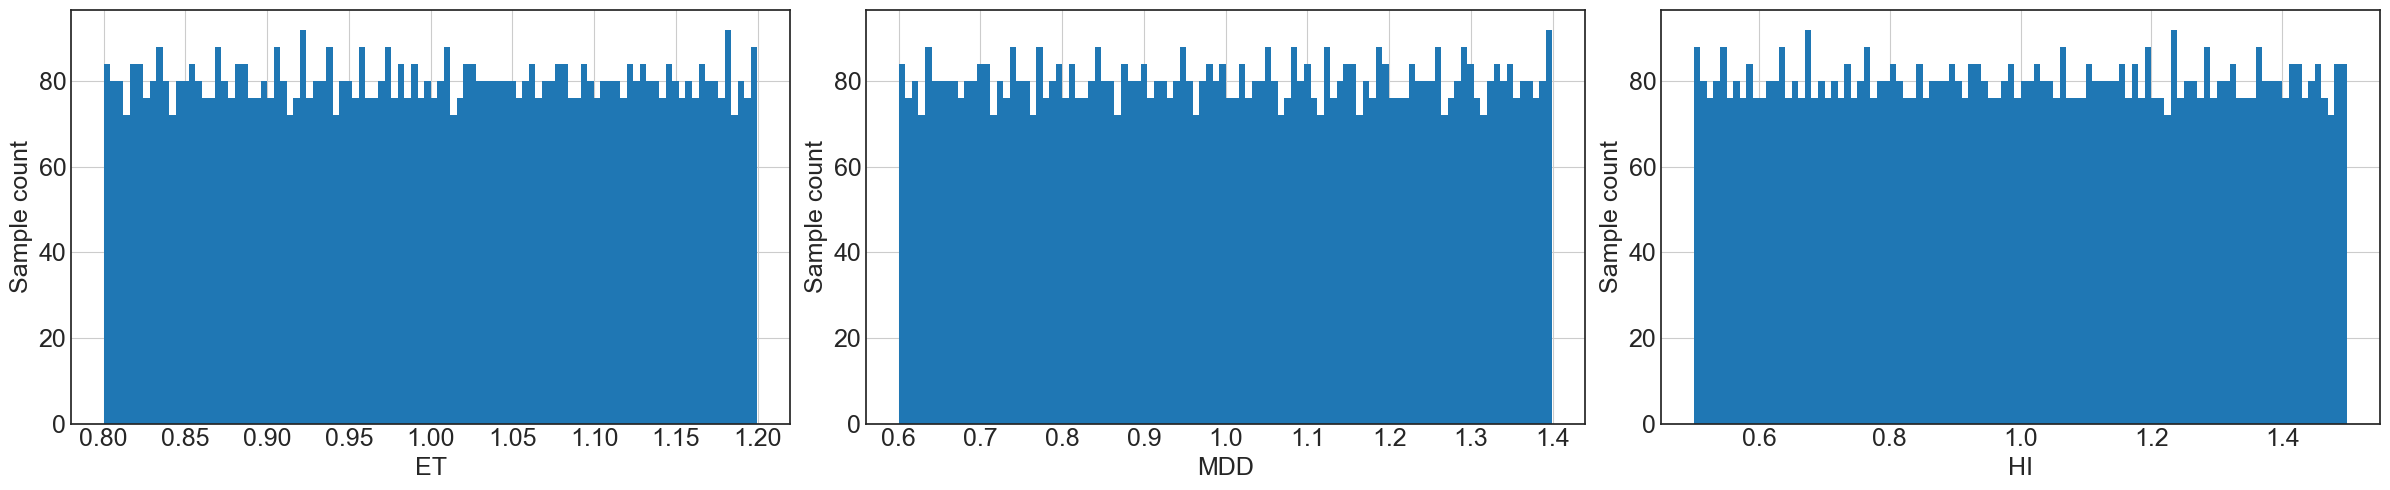

In [19]:
# plot the samples
unc_sample.plot_sample();

#### Calculate uncertainty
Calculates the uncertaintiy for the given return period scenario. For 1000 samples its quite time consuming,
so we provide the uncertainty files as .hdf5 files. 

In [20]:
#Parallel computing (does not work in the notebook usually, please use a python script if needed)

#from pathos.pools import ProcessPool as Pool
#pool = Pool()
#unc = calc_imp.uncertainty(unc_sample, rp=[], pool=pool,calc_eai_exp=True)
#pool.close() #Do not forget to close your pool!
#pool.join()
#pool.clear()

#safe uncertainty to .hdf5
#filename = DATA / 'uncertainty_file_name_30'
#unc.to_hdf5(filename)

The uncertainty files for all return periods are provided in the project folder on ENVIDAT

In [21]:
# read the .hdf5 files and use it for uncertainty analyses
filename = DATA /'uncertainty_file_name_30.hdf5'  #change path
unc30 = UncOutput.from_hdf5(filename) #file for the 30y return period

filename = DATA /'uncertainty_file_name_100.hdf5'  #change path
unc100 = UncOutput.from_hdf5(filename) #file for the 100y return period

filename = DATA /'uncertainty_file_name_300.hdf5'  #change path
unc300 = UncOutput.from_hdf5(filename) #file for the 300y return period

filename = DATA /'uncertainty_file_name_all.hdf5'  #change path
unc_all = UncOutput.from_hdf5(filename) #file for the combined scenario

#### Histogram plots
Climada provides its own uncertainty analysis based on histograms. To meet the comments of the reviewers we have made our own plots. These are generated with the following code. 

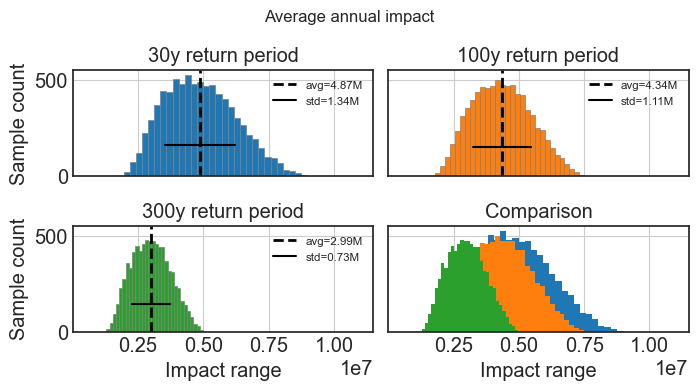

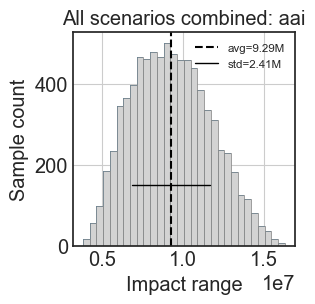

In [22]:
cm = 1/2.54
fig, axs = plt.subplots(2,2, sharex = True, sharey = True, figsize = (18 *cm, 10* cm))
ax = axs.ravel()


m_unit = ''

#axis 0
uncertainty_metrics = unc30.uncertainty_metrics
metric_list = [metric for metric in uncertainty_metrics]
unc_df = unc30.get_uncertainty(metric_list)
data_30 = unc_df['aai_agg'].to_numpy()
data_30 = pd.Series(data_30)
hist_30 = plt.hist(data_30, bins=30);
max_bin_30 = np.max(hist_30[0])
data_30.hist(ax=ax[0], bins=30, density=False, histtype='bar',
                      color='C0', edgecolor='gray',linewidth=0.5)

avg_30, std_30 = data_30.mean(), data_30.std()

ax[0].axvline(avg_30, color='black', linestyle='dashed', linewidth=2,
                    label="avg=%.2f%sM" %(avg_30/1000000, m_unit))
std_m_30, std_p_30 = avg_30 - std_30, avg_30 + std_30
ax[0].plot([std_m_30, std_p_30],
                   [0.3 * max_bin_30, 0.3 * max_bin_30], color='black',
                  label="std=%.2f%sM" %(std_30/1000000, m_unit))


#axis 1
uncertainty_metrics = unc100.uncertainty_metrics
metric_list = [metric for metric in uncertainty_metrics]
unc_df = unc100.get_uncertainty(metric_list)
data_100 = unc_df['aai_agg'].to_numpy()
data_100 = pd.Series(data_100)
hist_100 = plt.hist(data_100, bins=30);
max_bin_100 = np.max(hist_100[0])
data_100.hist(ax=ax[1], bins=30, density=False, histtype='bar',
                      color='C1', edgecolor='gray',linewidth=0.5)

avg_100, std_100 = data_100.mean(), data_100.std()

ax[1].axvline(avg_100, color='black', linestyle='dashed', linewidth=2,
                    label="avg=%.2f%sM" %(avg_100/1000000, m_unit))
std_m_100, std_p_100 = avg_100 - std_100, avg_100 + std_100
ax[1].plot([std_m_100, std_p_100],
                   [0.3 * max_bin_100, 0.3 * max_bin_100], color='black',
                  label="std=%.2f%sM" %(std_100/1000000, m_unit))
       
#axis 2
uncertainty_metrics = unc300.uncertainty_metrics
metric_list = [metric for metric in uncertainty_metrics]
unc_df = unc300.get_uncertainty(metric_list)
data_300 = unc_df['aai_agg'].to_numpy()
data_300 = pd.Series(data_300)
hist_300 = plt.hist(data_300, bins=30);
max_bin_300 = np.max(hist_300[0])
data_300.hist(ax=ax[2], bins=30, density=False, histtype='bar',
                      color='C2', edgecolor='gray',linewidth=0.5)

avg_300, std_300 = data_300.mean(), data_300.std()

ax[2].axvline(avg_300, color='black', linestyle='dashed', linewidth=2,
                    label="avg=%.2f%sM" %(avg_300/1000000, m_unit))
std_m_300, std_p_300 = avg_300 - std_300, avg_300 + std_300
ax[2].plot([std_m_300, std_p_300],
                   [0.3 * max_bin_300, 0.3 * max_bin_300], color='black',
                  label="std=%.2f%sM" %(std_300/1000000, m_unit))

#axis 3
ax[3].grid()





ax[2].set_xlabel('Impact range')
ax[3].set_xlabel('Impact range')

ax[0].set_ylabel('Sample count')
ax[2].set_ylabel('Sample count')





for axis in ax[:-1]:
    axis.legend(fontsize = 'small')

plt.subplots_adjust(hspace = 0.3, wspace = 0.1)
plt.xlim(1,11.5e6)
plt.suptitle('Average annual impact')
ax[0].set_title('30y return period')
ax[1].set_title('100y return period')
ax[2].set_title('300y return period')
ax[3].set_title('Comparison')
plt.tight_layout()
plt.savefig("H:\First_Paper\Fig_paper\Hist_30_100_300.pdf")  
plt.show()

#data, m_unit = u_vtm(unc_df_plt[0])
#print(data)

fig, ax = plt.subplots(1,1, figsize = (8 *cm, 8 *cm))

uncertainty_metrics = unc_all.uncertainty_metrics
metric_list = [metric for metric in uncertainty_metrics]
unc_df = unc_all.get_uncertainty(metric_list)
data_300 = unc_df['aai_agg'].to_numpy()
data_300 = pd.Series(data_300)
hist_300 = plt.hist(data_300, bins=30);
max_bin_300 = np.max(hist_300[0])
data_300.hist(ax=ax, bins=30, density=False, histtype='bar',
                      color='lightgray', edgecolor='gray',linewidth=0.5)

avg_300, std_300 = data_300.mean(), data_300.std()

ax.axvline(avg_300, color='black', linestyle='dashed',
                    label="avg=%.2f%sM" %(avg_300/1000000, m_unit))
std_m_300, std_p_300 = avg_300 - std_300, avg_300 + std_300
ax.plot([std_m_300, std_p_300],
                   [0.3 * max_bin_300, 0.3 * max_bin_300], color='black',
                  label="std=%.2f%sM" %(std_300/1000000, m_unit),linewidth=1)
plt.legend(fontsize = 'small')
plt.ylabel('Sample count')
plt.xlabel('Impact range')
plt.title('All scenarios combined: aai')
plt.tight_layout()
#plt.savefig("H:\First_Paper\Fig_paper\Hist_all.pdf")          

#### Damage Frequency Cuve
The damage frequency plots show, as described in the paper, which damages are to be expected for a certain return period, taking into account the uncertainties and comparing the single hazard scenarios to the uncertaity analyses. 

In [23]:
#multiply average annual impact aggregated with return period to get the damage
imp30 = unc30.get_uncertainty(['aai_agg'])
imp30['aai_agg'] = imp30['aai_agg']*30

imp100 = unc100.get_uncertainty(['aai_agg'])
imp100['aai_agg'] = imp100['aai_agg']*100

imp300 = unc300.get_uncertainty(['aai_agg'])
imp300['aai_agg'] = imp300['aai_agg']*300


#define the values for the damage frequency plot and calculate the percentiles
#for 30-year return period
RP30_p = imp30['aai_agg']
RP30_p5 = np.percentile(RP30_p, 5) # return 5th percentile,
RP30_p50 = np.percentile(RP30_p, 50) # return 50th percentile, e.g median.
RP30_p95 = np.percentile(RP30_p, 95) # return 95th percentile,
#for 100-year return period
RP100_p = imp100['aai_agg']
RP100_p5 = np.percentile(RP100_p, 5) # return 5th percentile,
RP100_p50 = np.percentile(RP100_p, 50) # return 50th percentile, e.g median.
RP100_p95 = np.percentile(RP100_p, 95) # return 95th percentile,
#for 300-year return period
RP300_p = imp300['aai_agg']
RP300_p5 = np.percentile(RP300_p, 5) # return 5th percentile,
RP300_p50 = np.percentile(RP300_p, 50) # return 50th percentile, e.g median.
RP300_p95 = np.percentile(RP300_p, 95) # return 95th percentile,

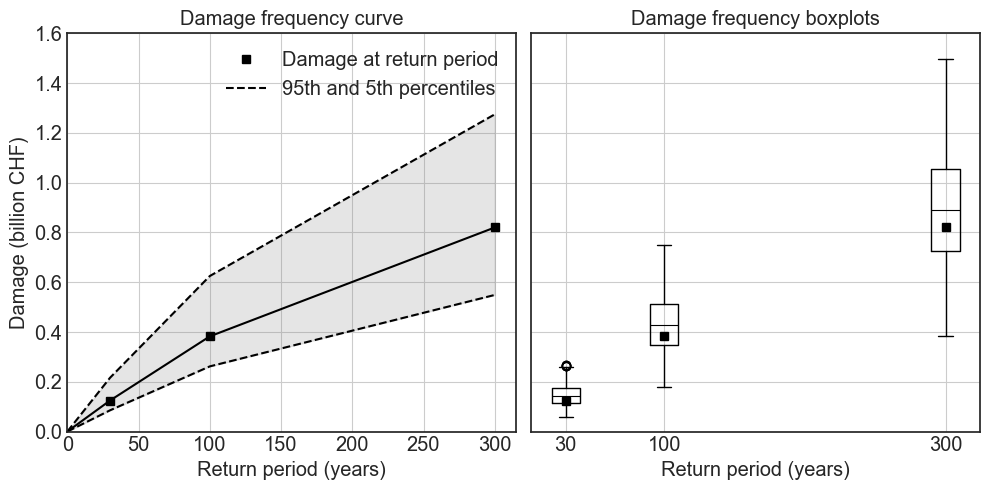

In [24]:
#creates the damage frequency plot
a = imp_Build_30.aai_agg  * 30
b = imp_Build_100.aai_agg * 100
c = imp_Build_300.aai_agg * 300
#subplots
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].plot([0,30,100,300], [0,a/1000000000,b/1000000000,c/1000000000], '-',color='black' )
ax[0].plot([30,100,300], [a/1000000000,b/1000000000,c/1000000000], 's',markersize = 6,color='black', label= "Damage at return period" )
ax[0].plot([0,30,100,300], [0,RP30_p95/1000000000,RP100_p95/1000000000,RP300_p95/1000000000], '--',color='black',label= "95th and 5th percentiles")
ax[0].plot([0,30,100,300], [0,RP30_p5/1000000000,RP100_p5/1000000000,RP300_p5/1000000000], '--',color='black')
#fill between and title
ax[0].fill_between([0,30,100,300], [0,RP30_p95/1000000000,RP100_p95/1000000000,RP300_p95/1000000000], [0,RP30_p5/1000000000,RP100_p5/1000000000,RP300_p5/1000000000], color='gray', alpha=0.2)
ax[0].set_title("Damage frequency curve")
ax[0].set_xlabel("Return period (years)")
ax[0].set_ylabel("Damage (billion CHF)")
ax[0].set_xlim(0,)
ax[0].legend()
ax[0].set_ylim(0,1.6)
ax[0].grid()
#ax[1] = fig.add_axes([0,0,1,1])
medianprops = dict(color="black",linewidth=0.8)
ax[1].boxplot([imp30['aai_agg']/1000000000,imp100['aai_agg']/1000000000,imp300['aai_agg']/1000000000],positions=[30,100,300],widths=(20,20,20),medianprops=medianprops)
#ax.boxplot(imp100['aai_agg'])
#plt.plot([30,100,300], [a,b,c], '--')
ax[1].plot([30,100,300], [a/1000000000,b/1000000000,c/1000000000], 's',markersize = 6, color='black')
ax[1].set_title("Damage frequency boxplots")
ax[1].set_xlabel("Return period (years)")
#ax[1].legend()

#grid and tight layout
plt.grid()
plt.tight_layout()

### Sensitivity analysis
The sensitivity analysis follows the Climada sensitivity module and shows which parameter has the biggest impact on the system. 

In [ ]:
#calculates sensitivity index S1 for the given return periods 30y, 100y and 300y
unc30_sens = calc_imp.sensitivity(unc30)
unc100_sens = calc_imp.sensitivity(unc100)
unc300_sens = calc_imp.sensitivity(unc300)

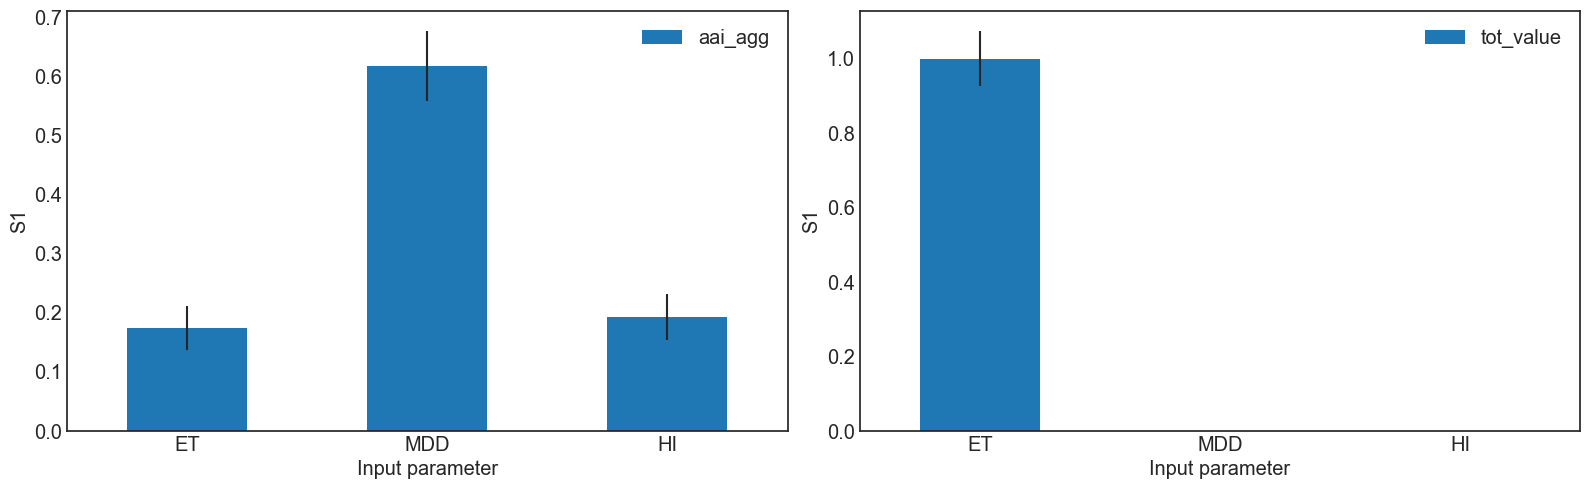

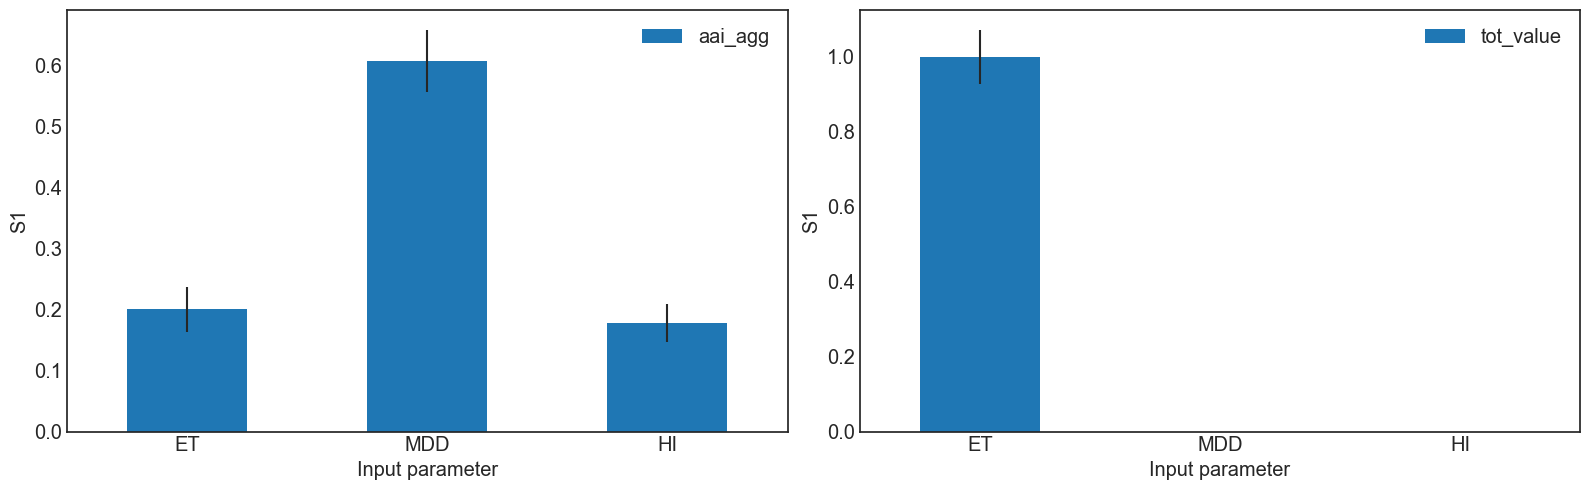

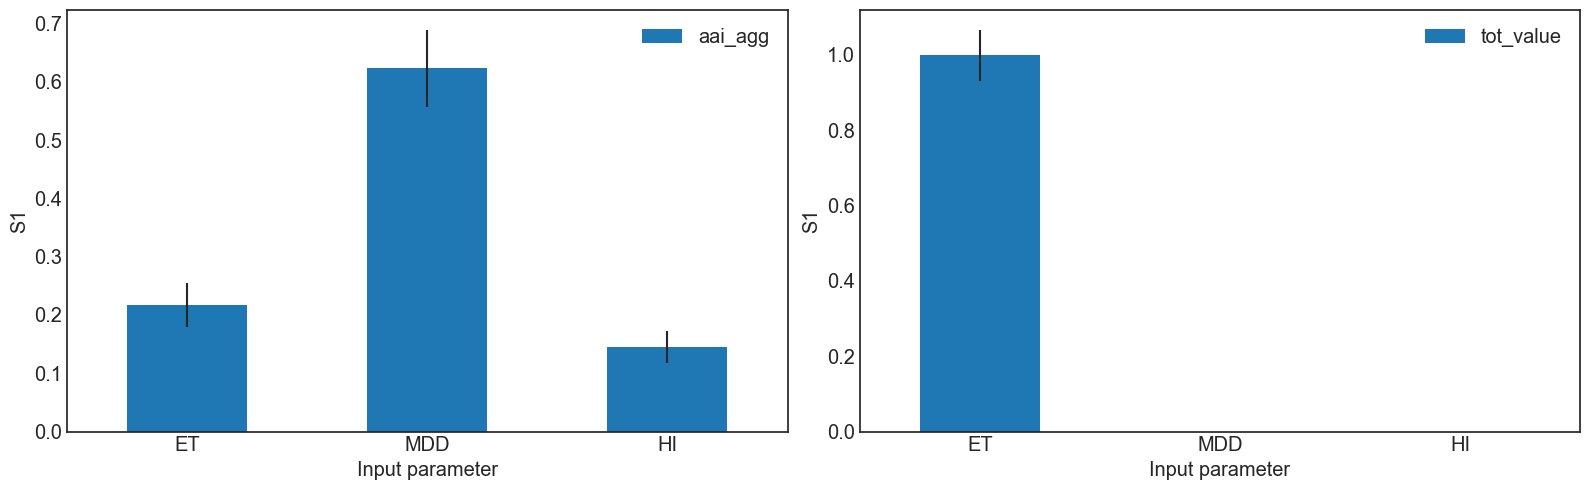

In [26]:
#plot sensitivity
unc30_sens.plot_sensitivity();
unc100_sens.plot_sensitivity();
unc300_sens.plot_sensitivity();
plt.legend()